# Holt Linear (Double Exponential Smoothing) — aprendizaje

## 1) Descomposición
$$ y_t = L_t + \varepsilon_t. $$

## 2) Modelo Holt (doble suavizamiento)
Recursiones:

$$ L_0=y_0,\quad B_0=y_1-y_0. $$
$$ L_t = \alpha y_t + (1-\alpha)(L_{t-1}+B_{t-1}). $$
$$ B_t = \beta(L_t - L_{t-1}) + (1-\beta) B_{t-1}. $$
Predicción un paso: $$ \hat y_t = L_{t-1} + B_{t-1},\ t\ge1. $$

## 3) Notación matricial
Estado $X_t=[L_t,B_t]'$ y entrada $y_t$:
$$ X_t = A X_{t-1} + K y_t,\quad \hat y_t = [1,\ 1] X_{t-1}. $$
con
$$ A = \begin{bmatrix} 1-\alpha & 1-\alpha \\ -\beta\alpha & 1-\beta\alpha \end{bmatrix},\quad K = \begin{bmatrix} \alpha \\ \beta\alpha \end{bmatrix}. $$

## 4) Carga y selección de $(\alpha,\beta)$ por MSE

In [ ]:
import csv, numpy as np
csv_path = 'cd/../data/air_passengers.csv'
fallback = [
('1949-01',112),('1949-02',118),('1949-03',132),('1949-04',129),
('1949-05',121),('1949-06',135),('1949-07',148),('1949-08',148),('1949-09',136)]

def try_load_csv(path):
    try:
        with open(path,'r',encoding='utf-8',newline='') as f:
            r = csv.DictReader(f)
            months, values = [], []
            for row in r:
                mk = next((k for k in row if k.lower().strip()=='month'), None)
                yk = next((k for k in row if k.lower().strip() in ('#passengers','passengers')), None)
                if mk is None or yk is None: continue
                months.append(row[mk].strip()); values.append(float(row[yk]))
            if values:
                return months, np.array(values, float)
    except Exception:
        pass
    return [m for m,_ in fallback], np.array([v for _,v in fallback], float)

months, y = try_load_csv(csv_path)
print('n=', len(y))

In [ ]:
import numpy as np
def holt_fit(y, alpha, beta):
    y = np.asarray(y, float); n=y.size
    L = np.empty(n, float); B = np.empty(n, float); yhat = np.empty(n, float)
    L[0]=y[0]; B[0]= y[1]-y[0] if n>=2 else 0.0; yhat[0]=y[0]
    for t in range(1,n):
        L[t] = alpha*y[t] + (1-alpha)*(L[t-1]+B[t-1])
        B[t] = beta*(L[t]-L[t-1]) + (1-beta)*B[t-1]
        yhat[t] = L[t-1] + B[t-1]
    err = y - yhat
    return L,B,yhat,err

alphas = np.linspace(0.01,0.99,99)
betas  = np.linspace(0.01,0.99,99)
best=None
for a in alphas:
    for b in betas:
        L,B,yhat,err = holt_fit(y,a,b)
        mse = float(np.mean(err[1:]**2))
        if best is None or mse<best['mse']:
            best={'alpha':float(a),'beta':float(b),'mse':mse,'L':L,'B':B,'yhat':yhat}
alpha_star, beta_star = best['alpha'], best['beta']
L,B,yhat = best['L'], best['B'], best['yhat']
print(f'alpha*={alpha_star:.3f}, beta*={beta_star:.3f}, MSE={best["mse"]:.3f}')

## 5) Pronóstico Holt
$$ \hat y_{n+h\,|\,n} = L_n + h B_n. $$

In [ ]:
import numpy as np
def holt_forecast(L_last,B_last,h):
    k = np.arange(1,h+1,dtype=float)
    return L_last + k*B_last

h=6
y_fc = holt_forecast(L[-1],B[-1],h)
print('Forecasts:', y_fc)

## 6) Gráficas (PNG)

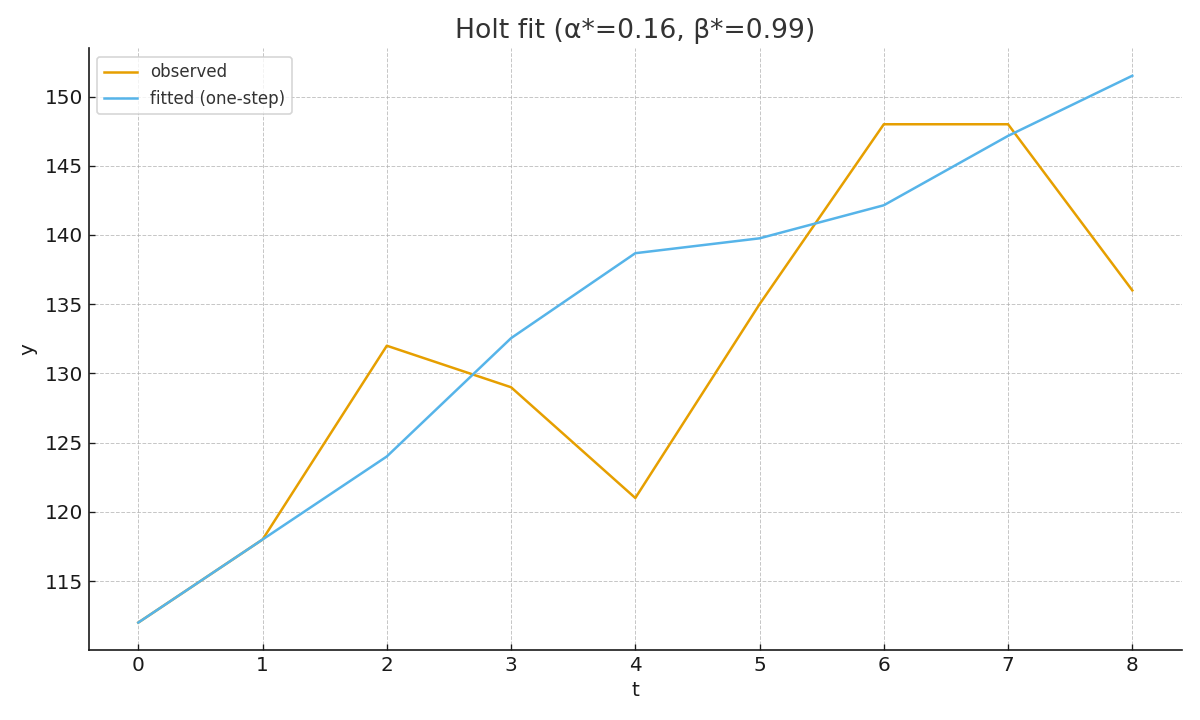

In [1]:
import matplotlib.pyplot as plt
import numpy as np
t = np.arange(len(y))
plt.figure(); plt.plot(t,y,label='observed'); plt.plot(t,yhat,label='fitted (one-step)')
plt.xlabel('t'); plt.ylabel('y'); plt.title(f'Holt fit (α*={alpha_star:.2f}, β*={beta_star:.2f})')
plt.legend(); plt.tight_layout(); plt.show()

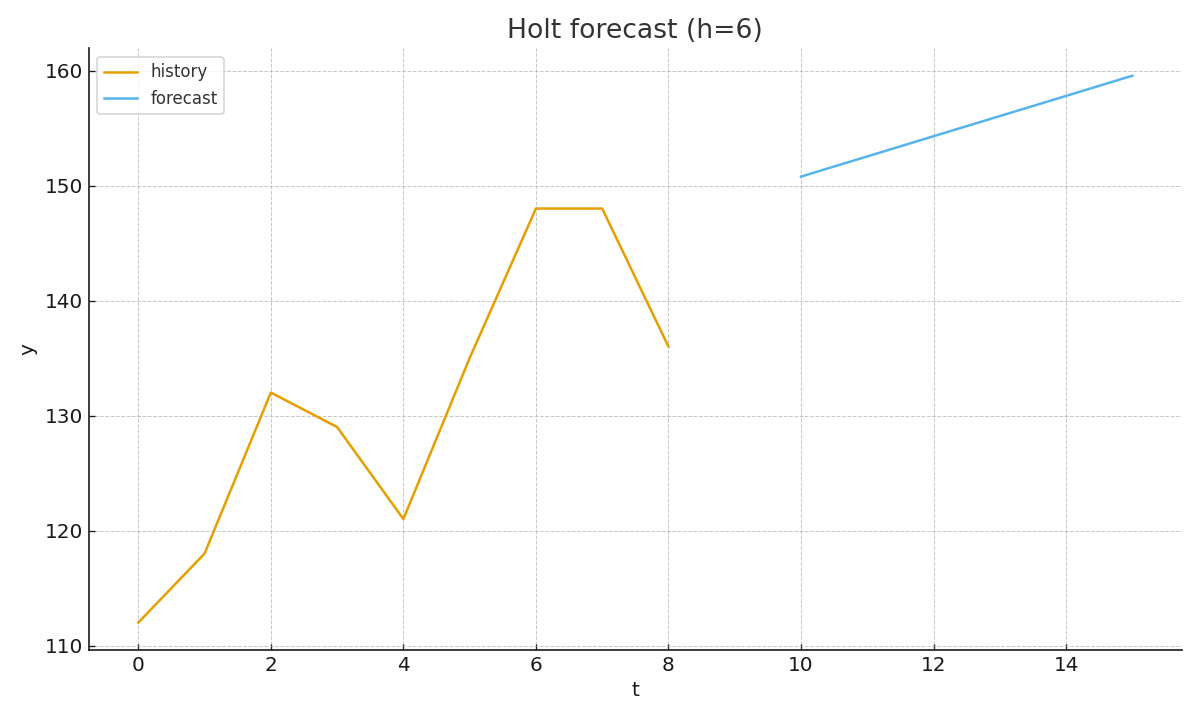

In [2]:
import matplotlib.pyplot as plt, numpy as np
t = np.arange(len(y))
plt.figure(); plt.plot(t,y,label='history'); plt.plot(np.arange(len(y)+1,len(y)+1+len(y_fc)), y_fc,label='forecast')
plt.xlabel('t'); plt.ylabel('y'); plt.title('Holt forecast (h=6)')
plt.legend(); plt.tight_layout(); plt.show()

### Notas
- Inicialización: $L_0=y_0,\ B_0=y_1-y_0$.
- $(\alpha,\beta)$ elegidos por MSE in-sample.
- Matrix form: $X_t = A X_{t-1} + K y_t$ con $A, K$ como arriba.